In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score
import timesynth as ts

from alibi_detect.od import SpectralResidual
from alibi_detect.utils.perturbation import inject_outlier_ts
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_ts

## Create univariate time series

Define number of sampled points.

In [2]:
n_points = 100000

In [3]:
# timestamps
time_sampler = ts.TimeSampler(stop_time=n_points // 4)
time_samples = time_sampler.sample_regular_time(num_points=n_points)

# harmonic oscillatting time series
sinusoid = ts.signals.Sinusoidal(frequency=0.25)
white_noise = ts.noise.GaussianNoise(std=0.1)
ts_harm = ts.TimeSeries(signal_generator=sinusoid, noise_generator=white_noise)
samples, signals, errors = ts_harm.sample(time_samples)
#X = samples.astype(np.float32)
X = samples.reshape(-1, 1).astype(np.float32)
print(X.shape)

(100000, 1)


Inject noise:

In [4]:
data = inject_outlier_ts(X, perc_outlier=10, perc_window=10, n_std=2., min_std=1.)
X_outlier, y_outlier, labels = data.data, data.target.astype(int), data.target_names
print(X_outlier.shape, y_outlier.shape)

(100000, 1) (100000,)


Visualize original and perturbed time series:

In [5]:
n_plot = 200

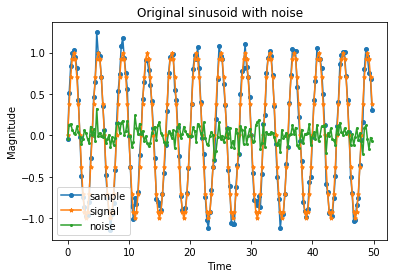

In [6]:
plt.plot(time_samples[:n_plot], X[:n_plot], marker='o', markersize=4, label='sample')
plt.plot(time_samples[:n_plot], signals[:n_plot], marker='*', markersize=4, label='signal')
plt.plot(time_samples[:n_plot], errors[:n_plot], marker='.', markersize=4, label='noise')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Original sinusoid with noise')
plt.legend()
plt.show();

Perturbed data:

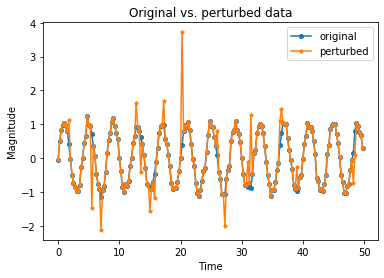

In [7]:
plt.plot(time_samples[:n_plot], X[:n_plot], marker='o', markersize=4, label='original')
plt.plot(time_samples[:n_plot], X_outlier[:n_plot], marker='*', markersize=4, label='perturbed')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Original vs. perturbed data')
plt.legend()
plt.show();

## Define Spectral Residual outlier detector

In [8]:
od = SpectralResidual(
    threshold=None, 
    window_amp=20,
    window_local=20,
    n_est_points=20,
    n_grad_points=5
)

Infer threshold:

In [9]:
od.infer_threshold(X_outlier, time_samples, threshold_perc=90)
print(od.threshold)

1.2188893616115641


## Detect outliers

Predict outliers:

In [10]:
od_preds = od.predict(X_outlier, time_samples, return_instance_score=True)

## Display results

F1 score and confusion matrix:

F1 score: 0.8954 -- Accuracy: 0.97908 -- Recall: 0.8954


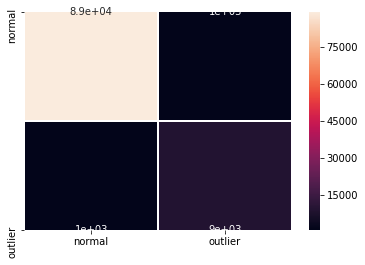

In [11]:
y_pred = od_preds['data']['is_outlier']
f1 = f1_score(y_outlier, y_pred)
acc = accuracy_score(y_outlier, y_pred)
rec = recall_score(y_outlier, y_pred)
print('F1 score: {} -- Accuracy: {} -- Recall: {}'.format(f1, acc, rec))
cm = confusion_matrix(y_outlier, y_pred)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(df_cm, annot=True, cbar=True, linewidths=.5)
plt.show()

Plot timestep level outlier scores vs. the outlier threshold. :

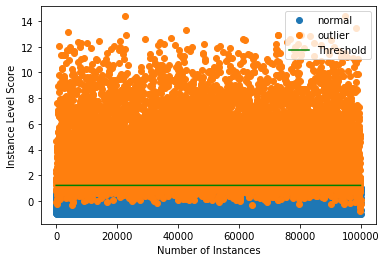

In [12]:
plot_instance_score(od_preds, y_outlier, labels, od.threshold)

Let's zoom in on a smaller time scale:

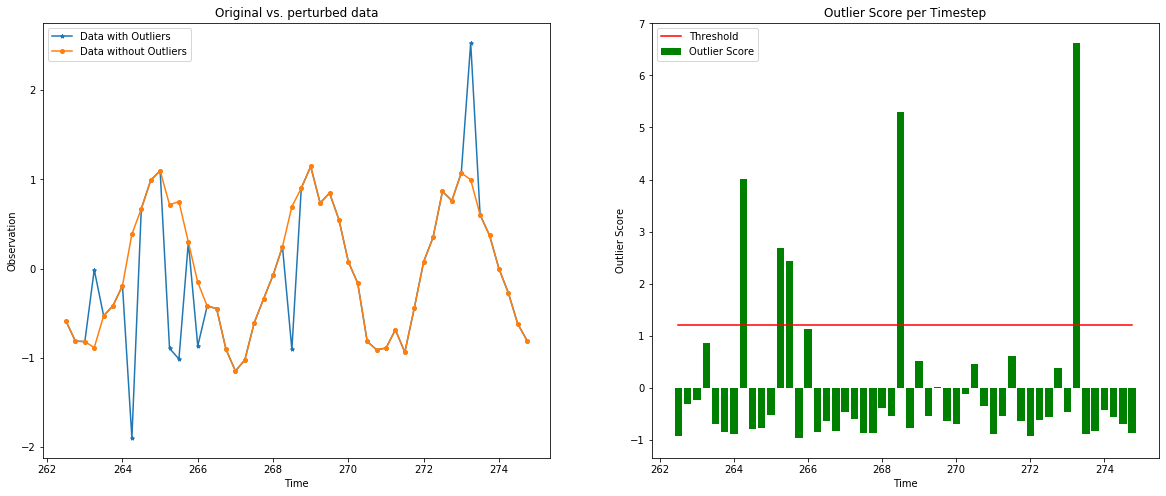

In [14]:
plot_feature_outlier_ts(od_preds, 
                        X_outlier, 
                        od.threshold,
                        window=(1050, 1100),
                        t=time_samples,
                        X_orig=X
                       )